In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib
from matplotlib import pyplot,pylab
plt = pyplot
import scipy
import seaborn as sns
sns.set_style('white')
import string
import pandas as pd
import json
import pymongo as pm
from glob import glob
from IPython.display import clear_output
import itertools 
from random import sample
import importlib
from PIL import Image

### set up project paths

In [2]:
## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..','..','..'))
data_dir = os.path.abspath(os.path.join(curr_dir,'..','data')) ## use relative paths
analysis_dir = os.path.abspath(os.path.join(curr_dir,'..','analysis')) ## use relative paths
plot_dir =  os.path.abspath(os.path.join(curr_dir,'..','results','plots'))
csv_dir = os.path.join(proj_dir, 'results','csv')

## add helpers to python path
import sys
if os.path.join(proj_dir, 'utils',) not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'utils'))
import helpers as h    

### inspect stims and get image paths 

In [3]:
## get stim paths
path_to_stim = './v0'
category_list = os.listdir(path_to_stim)
im_list = h.list_files(path_to_stim)

In [4]:
## sort stims in place
importlib.reload(h)
h.sort_nicely(im_list)

./v0/6_0_bear.png


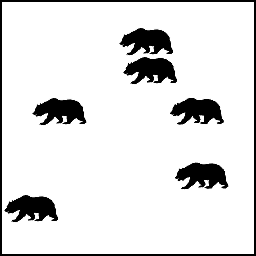

In [5]:
## manually inspect the images
imsize = 256
fname = im_list[30]
print(fname)
Image.open(fname).resize((imsize,imsize))

### upload stims to s3

In [6]:
import boto3
import botocore

In [7]:
bucket_name = 'iterated-number'
full_stim_paths = h.list_files(path_to_stim)
h.sort_nicely(full_stim_paths)

In [8]:
## helper to speed things up by not uploading images if they already exist, can be overriden 
def check_exists(s3, bucket_name, stim_name):
    try:
        s3.Object(bucket_name,stim_name).load()    
        return True
    except botocore.exceptions.ClientError as e:    
        if (e.response['Error']['Code'] == "404"):
            print('The object does not exist.')
            return False
        else:
            print('Something else has gone wrong with {}'.format(stim_name))

In [9]:
reallyRun = 1
if reallyRun: 
    ## tell user some useful information
    print('Path to stimuli is : {}'.format(path_to_stim))
    print('Uploading to this bucket: {}'.format(bucket_name))

    ## establish connection to s3 
    s3 = boto3.resource('s3')

    ## create a bucket with the appropriate bucket name
    try: 
        b = s3.create_bucket(Bucket=bucket_name) 
        print('Created new bucket.')
    except:
        b = s3.Bucket(bucket_name)
        print('Bucket already exists.')

    ## do we want to overwrite files on s3?
    overwrite = True
    
    ## set bucket and objects to public
    b.Acl().put(ACL='public-read') ## sets bucket to public

    ## now let's loop through stim paths and actually upload to s3 (woot!)
    for i,path_to_file in enumerate(full_stim_paths):
        stim_name = path_to_file.split('/')[-1]
        if ((check_exists(s3, bucket_name, stim_name)==False) | (overwrite==True)):
            print('Now uploading {} | {} of {}'.format(path_to_file.split('/')[-1],(i+1),len(full_stim_paths)))
            s3.Object(bucket_name,stim_name).put(Body=open(path_to_file,'rb')) ## upload stimuli
            s3.Object(bucket_name,stim_name).Acl().put(ACL='public-read') ## set access controls
        else: 
            print('Skipping {} | {} of {} because it already exists.'.format(path_to_file.split('/')[-1],(i+1),len(full_stim_paths)))
        clear_output(wait=True)

    print('Done uploading images!')

Done uploading images!
